# Io AMI Image Deconvolution

In [1]:
import os
os.chdir("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/amigo/src/amigo")

# autodiff
import jax
from jax import vmap, scipy as jsp, numpy as np, Array
import dLux as dl
import dLux.utils as dlu
import dLuxWebbpsf as dlW
from zodiax.experimental import deserialise
import equinox as eqx

# visualisation
import matplotlib.pyplot as plt
from matplotlib import colormaps, colors
import ehtplot
from geckos_colourmap import geckos_div

# astronomy
from astropy.io import fits
from astropy import units as u
import webbpsf
from xara.core import determine_origin

# optimisation
import optax

# AMIGO
from amigo.misc import planck
from amigo.files import get_files, summarise_files, full_to_SUB80, estimate_psf_and_bias, get_filters, initialise_params, get_exposures, get_Teffs
from amigo.core import Exposure, AMIOptics, SUB80Ramp, BaseModeller
from amigo.BFE import PolyBFE
from amigo.stats import check_symmetric, check_positive_semi_definite, total_read_noise, build_covariance_matrix
from amigo.detector_layers import model_ramp
from amigo.fitting import optimise

# files
from zodiax.experimental import serialise, deserialise


# matplotlib parameters
%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.size"] = 8

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_debug_nans", True)

sunset_dark = geckos_div(variation="geckos_sunset_darkred")
sunset = geckos_div(variation="geckos_sunset")

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


# Loading in Io Data
We have five Io exposures to load in, and four calibrator star exposures.

In [2]:
EXP_TYPE = "NIS_AMI"
FILTERS = ["F480M", "F430M", "F380M"]
# TARGPROP = ["HD-37093", "HD-36805"]
# TARGPROP = ["AB-DOR"]

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    "/Users/mcha5804/JWST/ERS1373/calgrps/",
    "calgrps",
    EXP_TYPE=EXP_TYPE,
    FILTER=FILTERS,
    **kwargs,
)

files = file_fn()

print(f"\n{len(files)}")
summarise_files(
    files,
    [
        # "ACT_ID",
        "APERNAME",
        "PUPIL",
        "SUBARRAY",
        "DETECTOR",
        "EXP_TYPE",
        "NINTS",
        "NGROUPS",
        "TGROUP",
        "OBSERVTN",
        "VISIT",
        "VISITGRP",
        "SEQ_ID",
        "ACT_ID",
        "EXPOSURE",
    ],
)


9
  APERNAME: NIS_AMI1
  PUPIL: NRM
  SUBARRAY: SUB80
  DETECTOR: NIS
  EXP_TYPE: NIS_AMI
  NINTS: 8, 100
  NGROUPS: 12, 45
  TGROUP: 0.07544
  OBSERVTN: 017, 023
  VISIT: 001
  VISITGRP: 04, 03
  SEQ_ID: 1
  ACT_ID: 02
  EXPOSURE: 4, 1, 5, 3, 2


Here we can print out the shapes of the data, and we can see the calibrators have 12 groups and the Io exposures have 45 groups.

In [3]:
# Check for duplicates
nsci = 2
sci_files = []

ncal = 3
cal_files = []

for file in files:
    if file[0].header["TARGPROP"] == "IO":
        sci_files.append(file)
    elif file[0].header["TARGPROP"] == "PSFCAL.2022A-HD2236-K6":
        cal_files.append(file)
    else:
        print(f"Unkown target: {file[0].header['TARGPROP']}")

sci_files = sci_files[:nsci]
cal_files = cal_files[4-ncal:]

for f in sci_files:
    print(f[0].header["TARGPROP"], f[1].data.shape)

for f in cal_files:
    print(f[0].header["TARGPROP"], f[1].data.shape)

IO (45, 80, 80)
IO (45, 80, 80)
PSFCAL.2022A-HD2236-K6 (12, 80, 80)
PSFCAL.2022A-HD2236-K6 (12, 80, 80)
PSFCAL.2022A-HD2236-K6 (12, 80, 80)


## Data visualisation
The calgrps files (exposures) are of shape $(\text{ngroups}, \text{npix}, \text{npix})$. Since we have up the ramp data, each exposure has $\text{ngroups}$ images, shown in the plot below. The title of the image is the peak pixel brightness of that image. The plot is simply the data from the first exposure. 

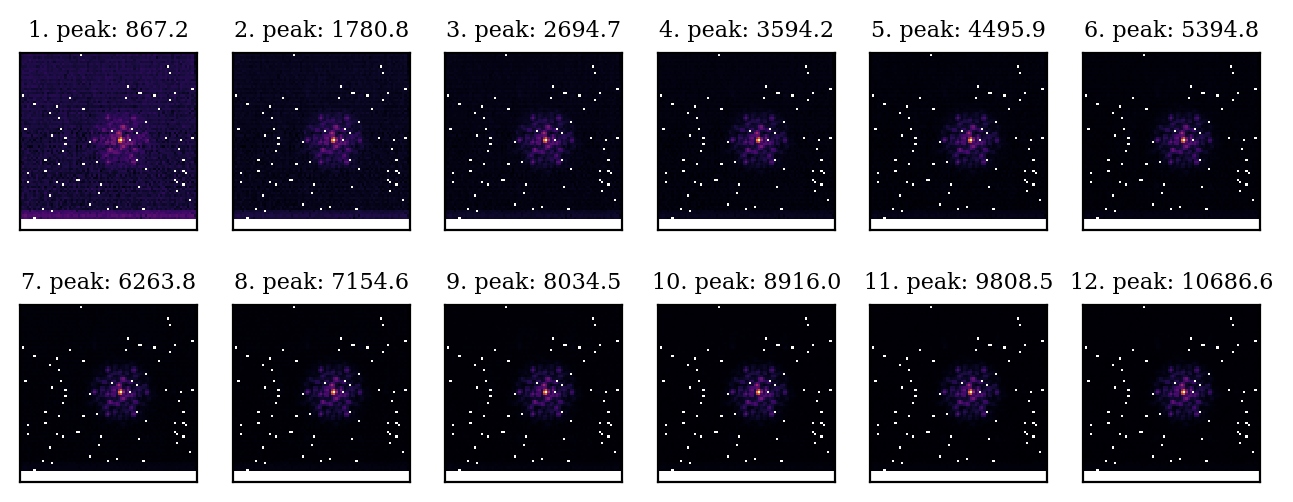

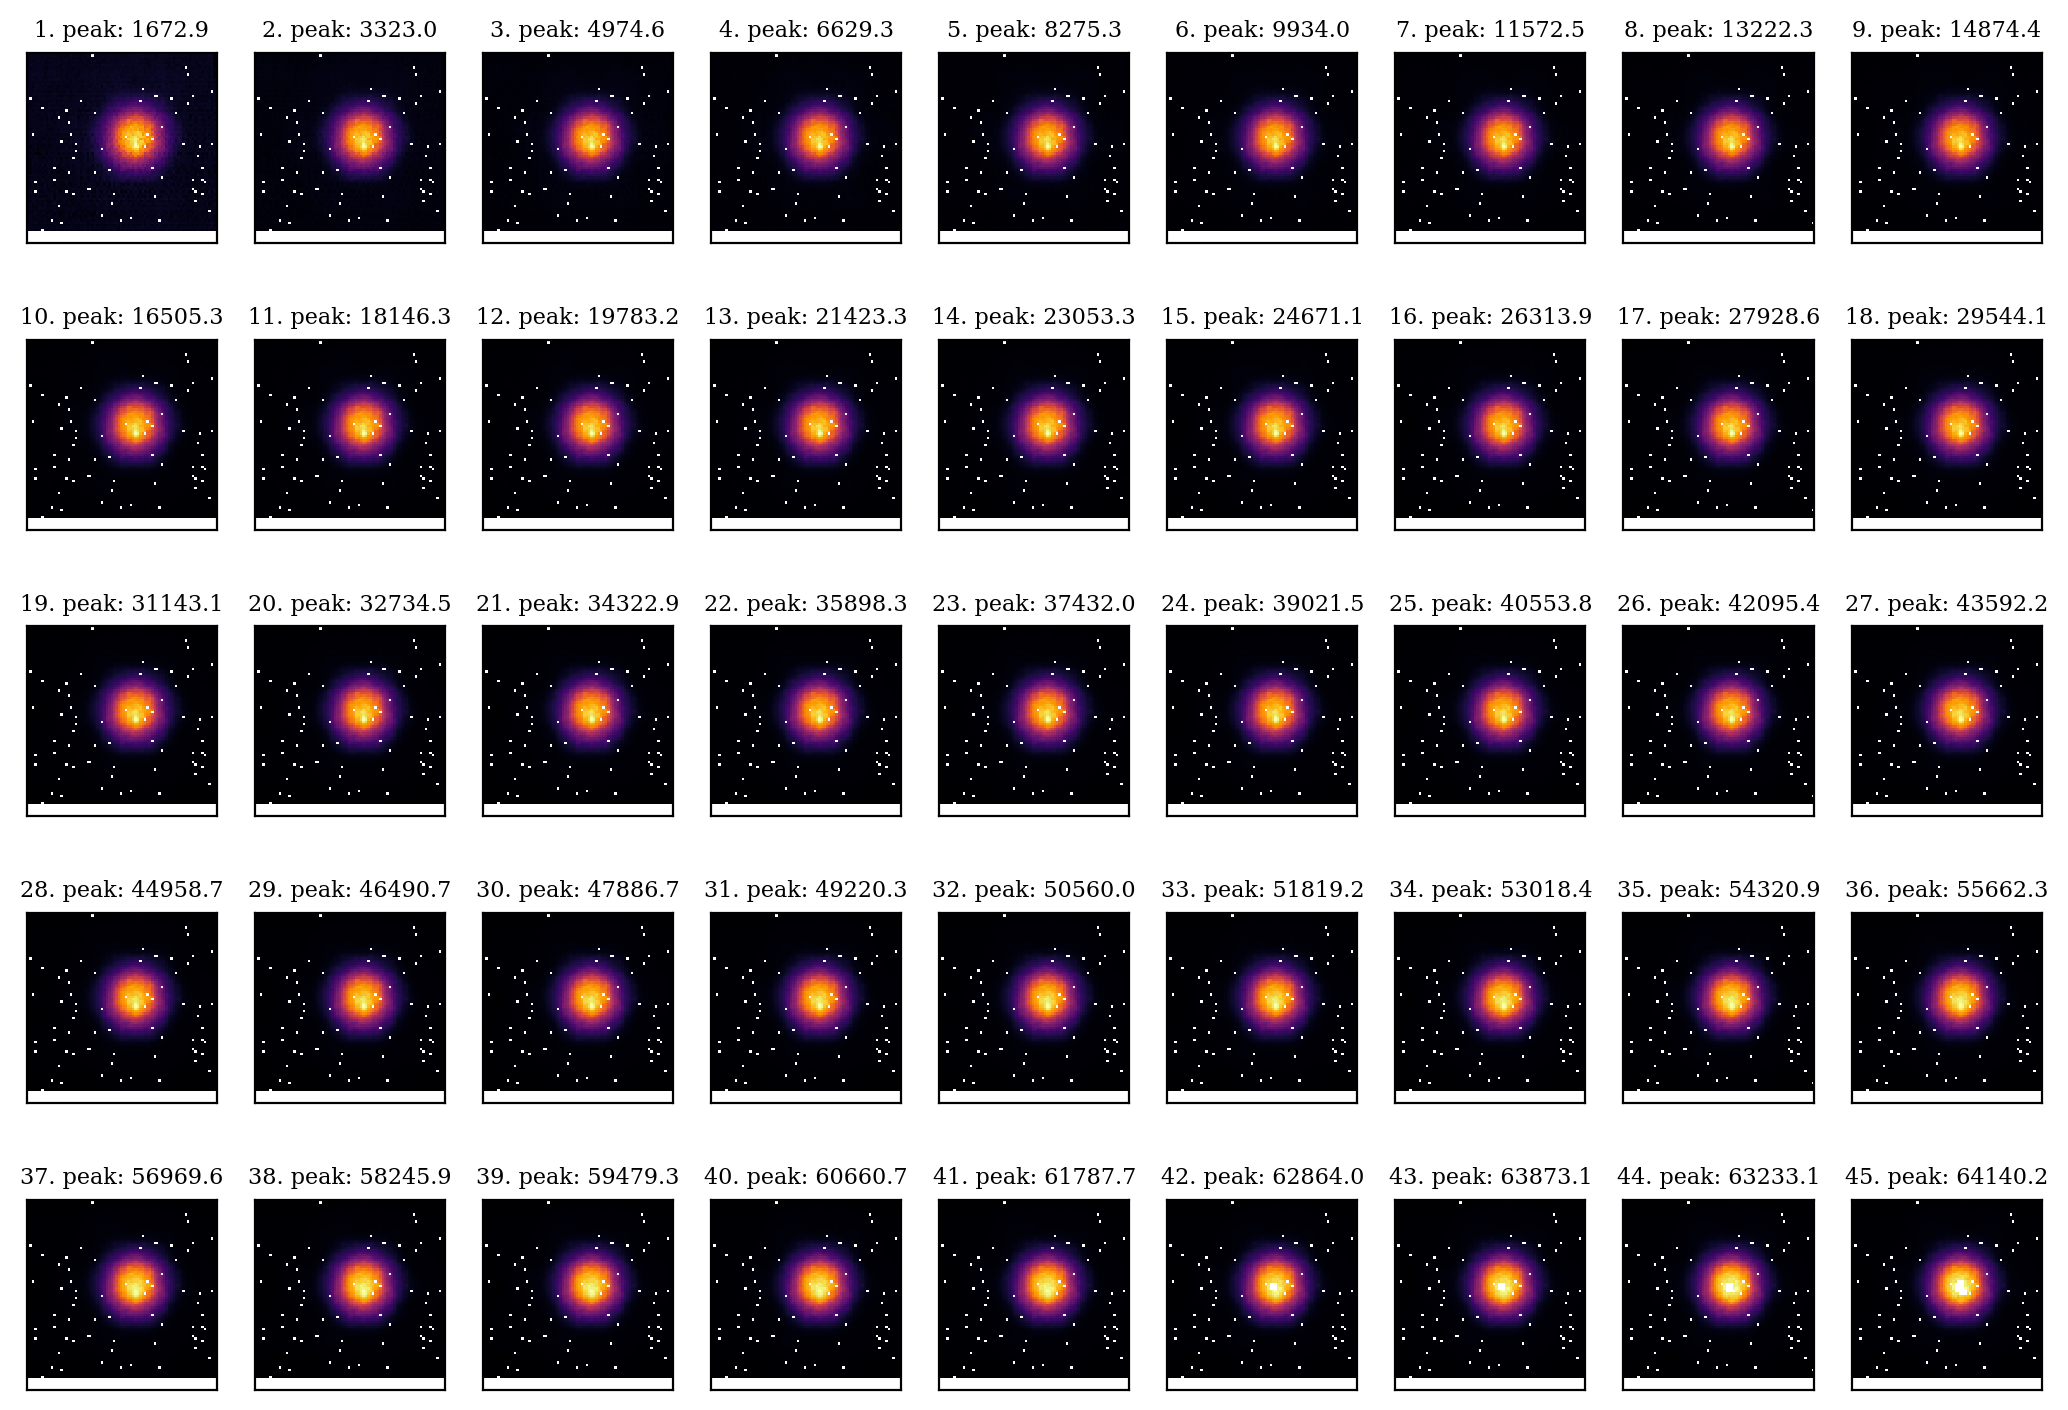

In [4]:
raw_data = np.asarray(cal_files[0][1].data, float)
# data = raw_data - raw_data[0]
cal_data = raw_data

plt.figure(figsize=(8, 3))
for i in range(12):
    plt.subplot(2, 6, i + 1)
    plt.title(f"{i+1}. peak: {np.nanmax(cal_data[i]):.1f}", size=8)
    plt.imshow(cal_data[i])
    plt.xticks([])
    plt.yticks([])
    # plt.colorbar()
plt.show()


raw_data = np.asarray(sci_files[0][1].data, float)
# data = raw_data - raw_data[0]
data = raw_data

plt.figure(figsize=(13, 9))
for i in range(45):
    plt.subplot(5, 9, i + 1)
    plt.title(f"{i+1}. peak: {np.nanmax(data[i]):.1f}", size=8)
    plt.imshow(data[i])
    plt.xticks([])
    plt.yticks([])
    # plt.colorbar()
plt.show()

# Building the model
First I am going to build some custom source classes.

In [5]:
from jax.scipy.signal import convolve
from dLux.sources import Source
from dLux.psfs import PSF
Optics = lambda: dl.optical_systems.BaseOpticalSystem
Spectrum = lambda: dl.spectra.BaseSpectrum

def initialise_disk(pixel_scale, oversample):
    io_initial_distance = 4.36097781166671 * u.AU
    io_final_distance = 4.36088492436330 * u.AU
    io_diameter = 3643.2 * u.km  # from wikipedia

    io_mean_distance = (io_initial_distance + io_final_distance).to(u.km) / 2
    angular_size = dlu.rad2arcsec(io_diameter / io_mean_distance)  # angular size in arcseconds

    print(f"Angular Size of Io: {angular_size:.4f} arcseconds, {angular_size / pixel_scale:.4f} pixels")

    npix = oversample * np.ceil(angular_size / pixel_scale).astype(int)
    coords = dlu.pixel_coords(npixels=npix, diameter=npix * pixel_scale / oversample)
    
    return dlu.circle(coords, radius=angular_size/2)


class IoSource(Source):
    """
    A single resolved source with a spectrum, position, flux, and distribution array
    that represents the resolved component.

    ??? abstract "UML"
        ![UML](../../assets/uml/ResolvedSource.png)

    Attributes
    ----------
    position : Array, radians
        The (x, y) on-sky position of this object.
    flux : float, photons
        The flux of the object.
    distribution : Array
        The array of intensities representing the resolved source.
    spectrum : Spectrum
        The spectrum of this object, represented by a Spectrum object.
    """

    distribution: Array
    log_flux: Array
    position: Array

    def __init__(
        self: Source,
        wavelengths: Array = None,
        position: Array | tuple = np.zeros(2),  # arcseconds
        log_flux: Array | float = 7.,
        distribution: Array = np.ones((3, 3)),
        weights: Array = None,
        spectrum: Spectrum() = None,
    ):
        """
        Parameters
        ----------
        wavelengths : Array, metres
            The array of wavelengths at which the spectrum is defined.
        position : Array, radians = np.zeros(2)
            The (x, y) on-sky position of this object.
        flux : float, photons = 1.
            The flux of the object.
        distribution : Array = np.ones((3, 3))
            The array of intensities representing the resolved source.
        weights : Array = None
            The spectral weights of the object.
        spectrum : Spectrum = None
            The spectrum of this object, represented by a Spectrum object.
        """
        distribution = np.asarray(distribution, dtype=float)
        self.distribution = distribution / distribution.sum()

        self.position = np.array(position, dtype=float)  # arcseconds
        self.log_flux = np.array(log_flux, dtype=float)

        if self.distribution.ndim != 2:
            raise ValueError("distribution must be a 2d array.")

        super().__init__(
            wavelengths=wavelengths, weights=weights, spectrum=spectrum
        )

    def model(
        self: Source,
        optics: Optics = None,
        return_wf: bool = False,
        return_psf: bool = False,
    ) -> Array:
        """
        Models the source object through the provided optics.

        Parameters
        ----------
        optics : Optics
            The optics through which to model the source object.
        return_wf : bool = False
            Should the Wavefront object be returned instead of the psf Array?
        return_psf : bool = False
            Should the PSF object be returned instead of the psf Array?

        Returns
        -------
        object : Array, Wavefront, PSF
            if `return_wf` is False and `return_psf` is False, returns the psf Array.
            if `return_wf` is True and `return_psf` is False, returns the Wavefront
                object.
            if `return_wf` is False and `return_psf` is True, returns the PSF object.
        """
        if return_wf and return_psf:
            raise ValueError(
                "return_wf and return_psf cannot both be True. "
                "Please choose one."
            )

        weights = self.weights * (10**self.log_flux)

        # Note we always return wf here so we can convolve each wavelength
        # individually if a chromatic wavefront output is required.
        wf = optics.propagate(
            self.wavelengths, dlu.arcsec2rad(self.position), weights, return_wf=True
        )

        # Returning wf is a special case
        if return_wf:
            conv_fn = lambda psf: convolve(psf, self.distribution, mode="same")
            return wf.set("amplitude", vmap(conv_fn)(wf.psf) ** 0.5)

        # Return psf object
        conv_psf = convolve(wf.psf.sum(0), self.distribution, mode="same")
        if return_psf:
            return PSF(conv_psf, wf.pixel_scale.mean())

        # Return array psf
        return conv_psf
    

class HD2236(Source):
    """
    A single resolved source with a spectrum, position, flux, and distribution array
    that represents the resolved component.

    ??? abstract "UML"
        ![UML](../../assets/uml/ResolvedSource.png)

    Attributes
    ----------
    position : Array, radians
        The (x, y) on-sky position of this object.
    flux : float, photons
        The flux of the object.
    distribution : Array
        The array of intensities representing the resolved source.
    spectrum : Spectrum
        The spectrum of this object, represented by a Spectrum object.
    """

    log_flux: Array
    position: Array

    def __init__(
        self: Source,
        wavelengths: Array = None,
        position: Array | tuple = np.zeros(2),  # arcseconds
        log_flux: Array | float = 5.8389,
        weights: Array = None,
        spectrum: Spectrum() = None,
    ):

        self.position = np.array(position, dtype=float)  # arcseconds
        self.log_flux = np.array(log_flux, dtype=float)

        if self.position.shape != (2,):
            raise ValueError("position must be a 1d array of shape (2,).")

        super().__init__(
            wavelengths=wavelengths, weights=weights, spectrum=spectrum
        )

    def model(
        self: Source,
        optics: Optics,
        return_wf: bool = False,
        return_psf: bool = False,
    ) -> Array:
        """
        Models the source object through the provided optics.

        Parameters
        ----------
        optics : Optics
            The optics through which to model the source object.
        return_wf : bool = False
            Should the Wavefront object be returned instead of the psf Array?
        return_psf : bool = False
            Should the PSF object be returned instead of the psf Array?

        Returns
        -------
        object : Array, Wavefront, PSF
            if `return_wf` is False and `return_psf` is False, returns the psf Array.
            if `return_wf` is True and `return_psf` is False, returns the Wavefront
                object.
            if `return_wf` is False and `return_psf` is True, returns the PSF object.
        """
        self = self.normalise()
        weights = self.weights * (10**self.log_flux)
        return optics.propagate(
            self.wavelengths, dlu.arcsec2rad(self.position), weights, return_wf, return_psf
        )


Now we finally build the models. Let's first load in the BFE and mask models.

In [6]:
BFE = deserialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/bfe/PolyBFE_trained.zdx")
pupil_mask = deserialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/bfe/PolyBFE_AMI_mask.zdx")

And now instantiate and initialise values for the model.

In [7]:
# Get webbpsf optical system for OPD
inst = webbpsf.NIRISS()
inst.load_wss_opd_by_date(files[0][0].header["DATE-BEG"], verbose=False)
opd = np.array(inst.get_optical_system().planes[0].opd)

# Get dLux optical system
optics = AMIOptics(
    opd=opd,
    pupil_mask=pupil_mask,
    # radial_orders=[0, 1, 2, 3],
    normalise=True,
    )

# Get detector and BFE
detector = SUB80Ramp()

# Processing exposures
cal_exposures = get_exposures(cal_files)
cal_params = initialise_params(cal_exposures)

sci_exposures = get_exposures(sci_files, ngroups=18)
sci_params = initialise_params(sci_exposures)

filters = get_filters(files)
wavels, weights = filters["F430M"]

cal_params["filters"] = filters; sci_params["filters"] = filters
cal_params["optics"] = optics; sci_params["optics"] = optics
cal_params["detector"] = detector; sci_params["detector"] = detector
cal_params["BFE"] = BFE; sci_params["BFE"] = BFE

# Set log_fluxes
def set_fluxes(exposures, log_flux):
    log_fluxes = {}
    for exp in exposures:
        log_fluxes[exp.key] = log_flux
    return log_fluxes

# Calibrator
cal_params["source"] = HD2236(
    wavelengths=wavels,
    weights=weights,
)
cal_params["Teffs"] = get_Teffs(cal_files)
cal_params["log_fluxes"] = set_fluxes(cal_exposures, 5.8)

# Io
sci_params["source"] = IoSource(
    distribution=initialise_disk(optics.psf_pixel_scale, optics.oversample),
    wavelengths=wavels,
    weights=weights,
    )
sci_params["log_fluxes"] = set_fluxes(sci_exposures, 7.0)

# models
initial_model = BaseModeller(sci_params)
cal_model = BaseModeller(cal_params)

 ** On entry to DGEBAL parameter number  3 had an illegal value
 ** On entry to DGEHRD parameter number  2 had an illegal value
 ** On entry to DHSEQR parameter number  4 had an illegal value
 ** On entry to DGEBAL parameter number  3 had an illegal value
 ** On entry to DGEHRD parameter number  2 had an illegal value
 ** On entry to DHSEQR parameter number  4 had an illegal value
 ** On entry to DGEBAL parameter number  3 had an illegal value
 ** On entry to DGEHRD parameter number  2 had an illegal value
 ** On entry to DHSEQR parameter number  4 had an illegal value
 ** On entry to DGEBAL parameter number  3 had an illegal value
 ** On entry to DGEHRD parameter number  2 had an illegal value
 ** On entry to DHSEQR parameter number  4 had an illegal value
 ** On entry to DGEBAL parameter number  3 had an illegal value
 ** On entry to DGEHRD parameter number  2 had an illegal value
 ** On entry to DHSEQR parameter number  4 had an illegal value
 ** On entry to DGEBAL parameter number 

And finally let's define a model function since we are using the `BaseModeller`.

In [8]:
def model_fn(model, exposure, to_BFE=False):
    # Get exposure key
    key = exposure.key

    # Updating source weights
    wavels, filt_weights = model.filters[exposure.filter]
    if exposure.star == "IO":
        weights = filt_weights  # TODO spectrum
    elif exposure.star == "PSFCAL.2022A-HD2236-K6":
        weights = filt_weights * planck(wavels, model.Teffs[exposure.star])  
    # weights *= 10 ** (model.log_fluxes[key]) / weights.sum()

    source = model.source.set(
        ["position", "log_flux", "wavelengths", "weights"],
        [model.positions[key], model.log_fluxes[key], wavels, weights],
    )
    
    # Apply correct aberrations
    optics = model.optics.set(
        ["coefficients", "pupil.opd"],
        [model.aberrations[key], exposure.opd],
    )

    # Make sure this has correct position units and get wavefronts
    PSF = source.model(optics, return_psf=True)

    # Apply the detector model and turn it into a ramp
    psf = model.detector.model(PSF)
    ramp = model_ramp(psf, exposure.ngroups)

    if to_BFE:
        return ramp

    # Now apply the CNN BFE and downsample
    ramp = eqx.filter_vmap(model.BFE.apply_array)(ramp)
    ramp = vmap(dlu.resize, (0, None))(ramp, 80)

    # Apply bias and one of F correction
    ramp += total_read_noise(model.biases[key], model.OneOnFs[key])
    return ramp

# Calibrator Fit

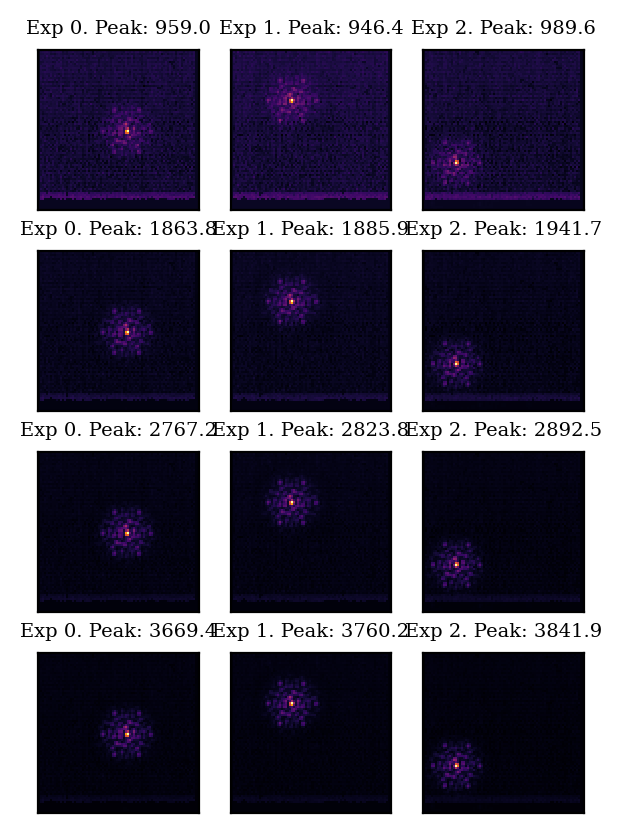

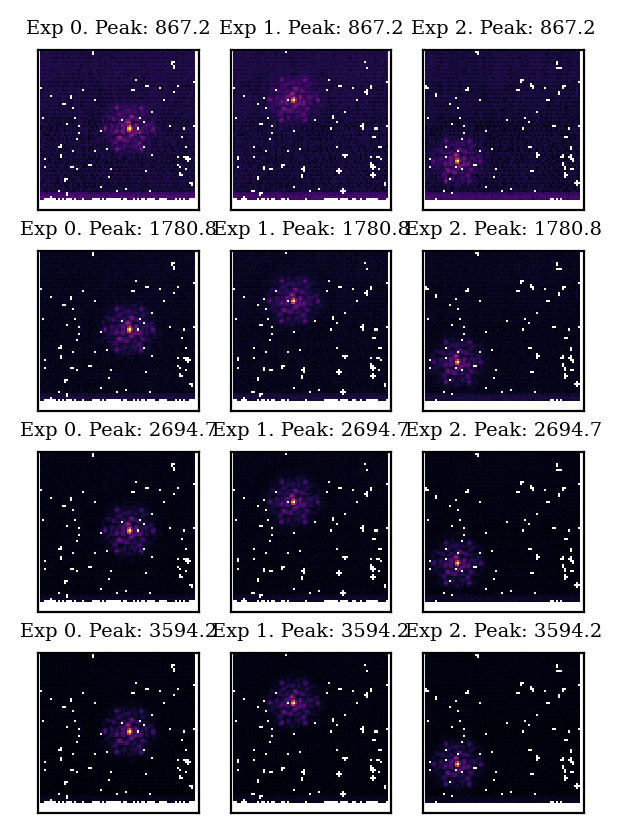

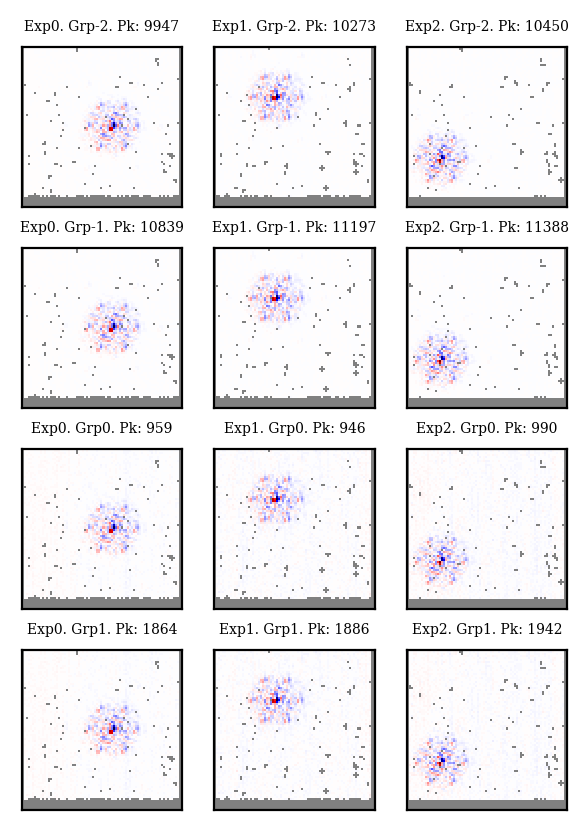

In [9]:
def get_residual_bounds(arr: Array):
    extent = np.nanmax(np.abs(arr))
    bound_dict = {
        "vmin": -extent,
        "vmax": extent,
        "cmap": seismic
    }
    return bound_dict


def get_residuals(arr1: Array, arr2: Array, return_bounds: bool = False):
    arr1 = np.array(arr1)
    arr2 = np.array(arr2)
    residuals = (arr1 - arr2)

    if return_bounds:
        bound_dict = get_residual_bounds(residuals)
        return residuals, bound_dict
    
    return residuals


plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(cal_exposures):
    psf_ramp = model_fn(cal_model, exp)
    for group_idx in range(4):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(psf_ramp[group_idx]):.1f}", size=7)
        plt.imshow(psf_ramp[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()

plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(cal_exposures):
    data = exp.data
    for group_idx in range(4):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(cal_data[group_idx]):.1f}", size=7)
        plt.imshow(data[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()

plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(cal_exposures):
    data = exp.data
    psf_ramp = model_fn(cal_model, exp)
    for i, group_idx in enumerate(np.arange(-2, 2)):
        residuals, bounds = get_residuals(psf_ramp[group_idx], exp.data[group_idx], return_bounds=True)
        plt.subplot(4, 5, exp_idx + 5 * i + 1)
        plt.title(f"Exp{exp_idx}. Grp{group_idx}. Pk: {np.nanmax(psf_ramp[group_idx]):.0f}", size=5)
        plt.imshow(residuals, **bounds)
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()


## Optimisation

In [10]:
def bias_prior(model, exposure, mean=80, std=50):
    # Estimated std is ~25, so we use 50 here to be conservative
    # Estimated mean is taken from the initial bias estimation
    bias_vec = model.biases[exposure.key][*exposure.support]
    return jsp.stats.norm.logpdf(bias_vec, loc=mean, scale=std).sum()


def posterior(model, exposure, per_pix=True):
    ramp = model_fn(model, exposure)
    
    loglike = exposure.loglike_vec(ramp).sum()
    logprior = bias_prior(model, exposure).sum()

    posterior = loglike + logprior
    if per_pix:
        return posterior / np.prod(np.array(exposure.data.shape[-2:]))
    return posterior


def loss_fn(model, exposures):
    loss = -np.array([posterior(model, exp) for exp in exposures])
    return loss.sum()

delay = lambda lr, s: optax.piecewise_constant_schedule(lr * 1e-16, {s: 1e16})
opt = lambda lr, start: optax.sgd(delay(lr, start), nesterov=True, momentum=0.5)
adam_opt = lambda lr, start: optax.adam(delay(lr, start))
clip = lambda optimiser, v: optax.chain(optimiser, optax.clip(v))

In [11]:
config = {
    "positions": opt(2e-6, 0),
    "aberrations":  opt(1e2, 8),
    # # # "aberrations":  clip(adam_opt(1e1, 30), 8),
    "log_fluxes": opt(2e-5, 15),
    
    # # Read noise refinement
    # "OneOnFs": opt(1e3, 60),
    # "biases": opt(5e4, 50),

    # BFE
    "BFE.linear": opt(2e-7, 30),
    "BFE.quadratic": opt(5e-17, 35),
}

# params = list(config.keys())

# Optimisation
cal_final_model, cal_losses, cal_params_out, cal_opt_state = optimise(
    cal_model,
    cal_exposures,
    loss_fn,
    5000,
    config,
    print_grads=False,
    return_state=True,
    nan_method="none",
)

Step fn compiling...
Compile Time: 0:00:14
Initial Loss: 2,730.35


Loss: 2,730.35, Change: 0.0:   0%|          | 0/4999 [00:00<?, ?it/s]

Compile Time: 5:39:07
Final Loss: 174.34


In [12]:
# no_bfe = cal_final_model.set("BFE", PolyBFE(ksize=5, oversample=1, orders=[1, 2]))

# red, bd = get_residuals(model_fn(cal_final_model, cal_exposures[0])[-1], model_fn(no_bfe, cal_exposures[0])[-1], return_bounds=True)
# plt.imshow(red, **bd)
# plt.colorbar()
# plt.show()

## Visualisation

In [13]:
def plot_params(losses, params_out, format_fn, k=10, l=-1):
    # nparams = len(params_out.keys())
    # nplots = (nparams + 1) // 2

    plt.figure(figsize=(9, 3))
    plt.subplot(1, 2, 1)
    plt.title("Full Loss")
    plt.plot(losses)

    if k >= len(losses):
        k = 0
    last_losses = losses[k:l]
    n = len(last_losses)
    plt.subplot(1, 2, 2)
    plt.title(f"Final {n} Losses")
    plt.plot(np.arange(k, k + n), last_losses)

    plt.tight_layout()
    plt.show()

    params = list(params_out.keys())
    for i in np.arange(0, len(params), 2):
        fig = plt.figure(figsize=(9, 3))
        ax = plt.subplot(1, 2, 1)
        # plt.title(params[i])
        ax = format_fn(params_out, params[i], ax=ax)
        # plt.plot(format_fn(params_out, params[i]))

        ax = plt.subplot(1, 2, 2)
        if i + 1 == len(params):
            plt.tight_layout()
            plt.show()
            break
        # plt.title(params[i + 1])
        # plt.plot(format_fn(params_out, params[i + 1]))
        ax = format_fn(params_out, params[i + 1], ax=ax)

        plt.tight_layout()
        plt.show()


def invert_params(params):
    """Takes in a dictionary of a list of parameters and returns a 2D array of values"""
    vals = []
    for p in params.keys():
        v = np.array(params[p])
        v = v.reshape(v.shape[0], -1)
        vals.append(v)
    vals = np.concatenate(vals, axis=-1)
    return vals


def format_fn(params_out, param, ax, alpha=0.75):
    ax.set(title=param, xlabel="Epochs")

    leaf = params_out[param]
    if isinstance(leaf, list):
        arr = np.array(leaf)
    elif param == "stars":
        pass
    else:
        arr = invert_params(leaf)

    if param == "distribution":
        arr = arr.reshape(arr.shape[0], -1)
        ax.plot(arr, alpha=0.05, linewidth=1)
        ax.set(ylabel="Source Distribution")
        ax.axhline(0, color='k', linestyle='--')

    elif param == "positions":
        arr = arr.reshape(arr.shape[0], -1)
        ax.plot(arr - arr[0])
        ax.set(ylabel="Position (arcsec)")

    elif param == "log_fluxes":
        arr = arr.reshape(arr.shape[0], -1)
        ax.plot(arr)
        ax.set(ylabel="Flux (photons)")

    elif "aberrations" in param:
        arr = arr.reshape(arr.shape[0], -1)
        arr -= arr[0]
        ax.plot(arr - arr[0], alpha=0.25)
        ax.set(ylabel="Aberrations (nm)")

    elif "OneOnFs" in param:
        arr = arr.reshape(arr.shape[0], -1)
        ax.plot(arr - arr[0], alpha=0.25)
        ax.set(ylabel="OneOnFs")

    elif "BFE.linear" in param:
        arr = arr.reshape(len(arr), -1)
        ax.plot(arr - arr[0], alpha=0.5, linewidth=1)
        ax.set(ylabel="BFE Linear")

    elif "BFE.quadratic" in param:
        arr = arr.reshape(len(arr), -1)
        ax.plot(arr - arr[0], alpha=0.5)
        ax.set(ylabel="BFE Quadratic")

    elif "pupil_mask.holes" in param:
        arr = arr.reshape(len(arr), -1)
        arr -= arr[0]
        arr *= 1e3
        ax.plot(arr, alpha=alpha)
        ax.set(ylabel="Pupil Mask Holes (mm)")

    elif "bias" in param:
        arr = arr.reshape(len(arr), -1)
        ax.plot(arr - arr[0], alpha=0.25)
        ax.set(ylabel="Bias")

    elif "PRF" in param:
        ax.plot(arr.reshape(len(arr), -1), alpha=0.25)
        ax.set(ylabel="PRF")

    elif "rotation" in param:
        ax.plot(dlu.rad2deg(arr))
        ax.set(ylabel="Rotation (deg)")

    elif "stars" in param:
        Teffs = []
        for star in leaf.values():
            Teffs.append(np.array([s.Teff for s in star]))
        Teffs = np.array(Teffs).T
        ax.plot(Teffs)
        ax.set(ylabel="Stellar Teff (K)")

    else:
        print(param)
        ax.plot(arr)

    return ax


def plotting_cal_comparison(model, exposures, losses):

    nrows = 2 * len(exposures)

    plt.figure(figsize=(15, 3*nrows))

    for exp_idx, exp in enumerate(exposures):
        
        model_imgs = model_fn(model, exp)

        for grp_idx, grp_no in enumerate(np.arange(-1, 1)):
            plt.subplot(nrows, 4, 1 + 4*grp_idx + 8*exp_idx)
            plt.imshow(model_imgs[grp_no], cmap=inferno, vmin=0,)
            plt.colorbar()
            plt.title(f"Model Image. Exp:{exp_idx}, Grp:{grp_no}")
            plt.xticks([0, model_imgs[grp_no].shape[0]-1])
            plt.yticks([0, model_imgs[grp_no].shape[1]-1])

            plt.subplot(nrows, 4, 2 + 4*grp_idx + 8*exp_idx)
            plt.imshow(exp.data[grp_no], cmap=inferno, vmin=0,)
            plt.colorbar(label=None)
            plt.title(f"Data. Exp:{exp_idx}, Grp:{grp_no}")
            plt.xticks([0, model_imgs[grp_no].shape[0]-1])
            plt.yticks([0, model_imgs[grp_no].shape[1]-1])

            residuals, bound_dict = get_residuals(model_imgs[grp_no], exp.data[grp_no], return_bounds=True)
            plt.subplot(nrows, 4, 3 + 4*grp_idx + 8*exp_idx)
            plt.imshow(residuals, **bound_dict)
            plt.colorbar(label="flux")
            plt.title(f"Residuals. Exp:{exp_idx}, Grp:{grp_no}")
            plt.xticks([0, model_imgs[grp_no].shape[0]-1])
            plt.yticks([0, model_imgs[grp_no].shape[1]-1])

            llim = exp.loglike_im(model_imgs)
            plt.subplot(nrows, 4, 4 + 4*grp_idx + 8*exp_idx)
            plt.imshow(-llim)
            plt.colorbar()
            plt.title(f"Neg Log Likelihood")
            plt.xticks([0, model_imgs[grp_no].shape[0]-1])
            plt.yticks([0, model_imgs[grp_no].shape[1]-1])

    plt.show()


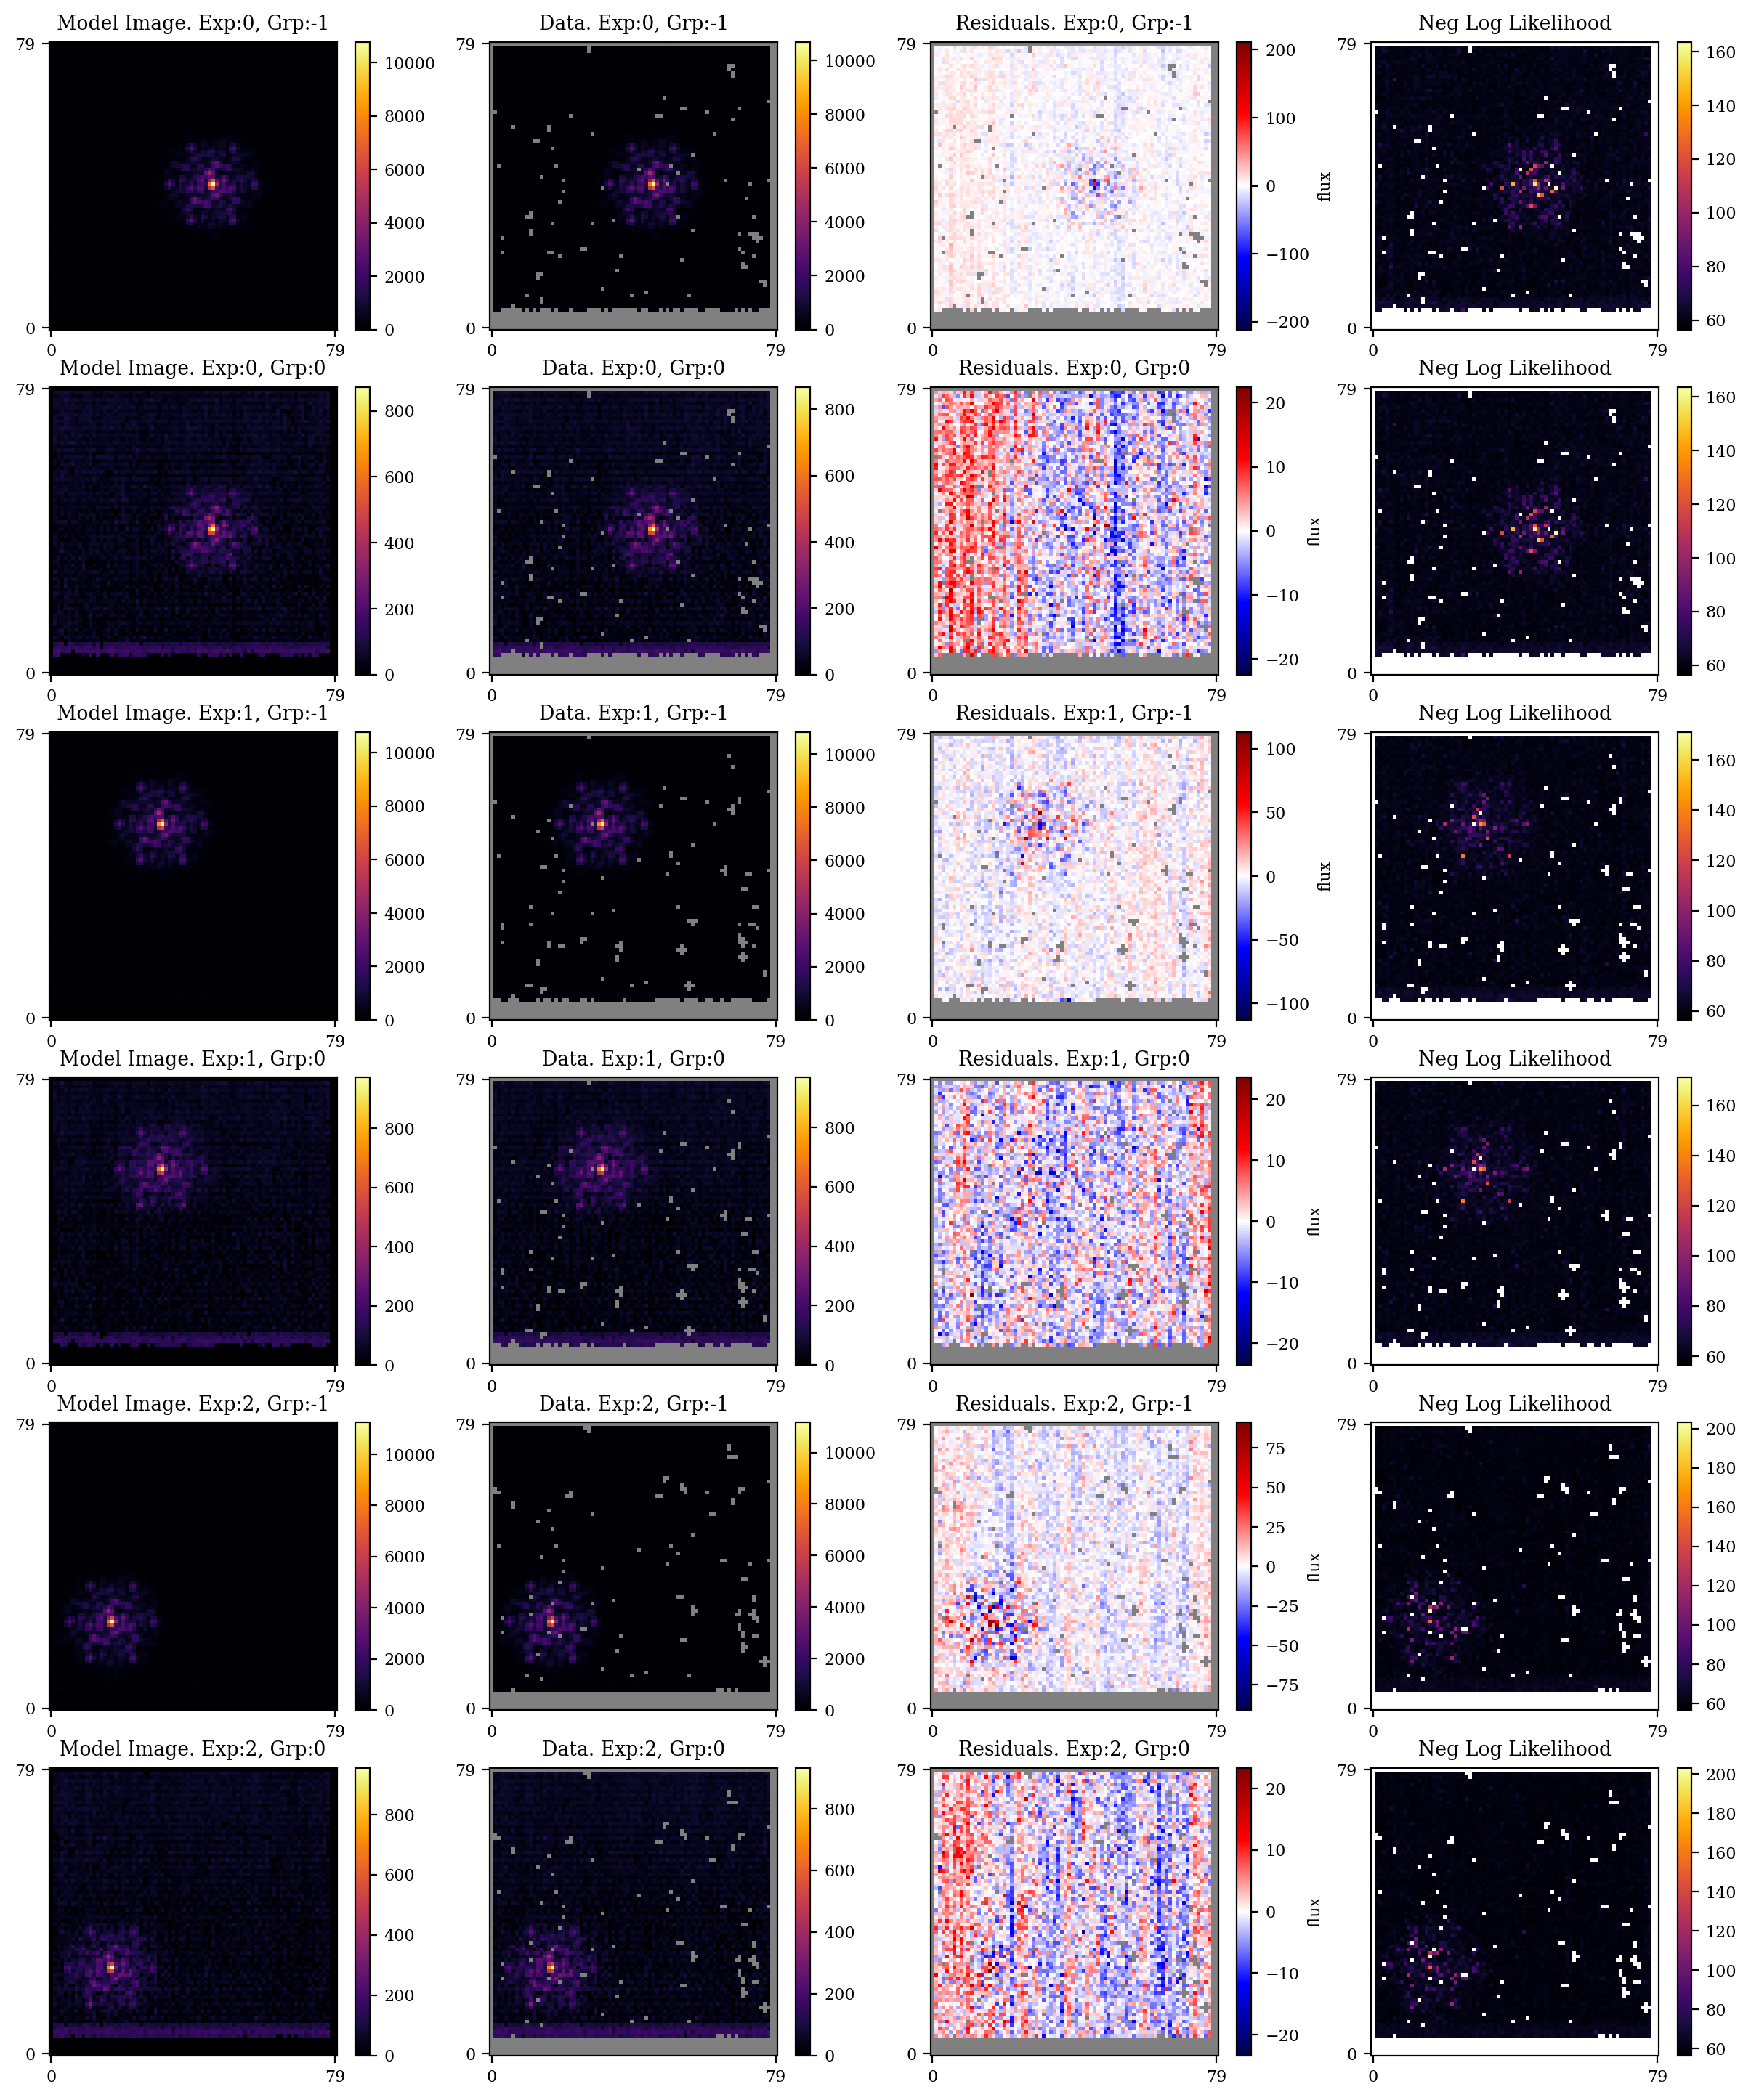

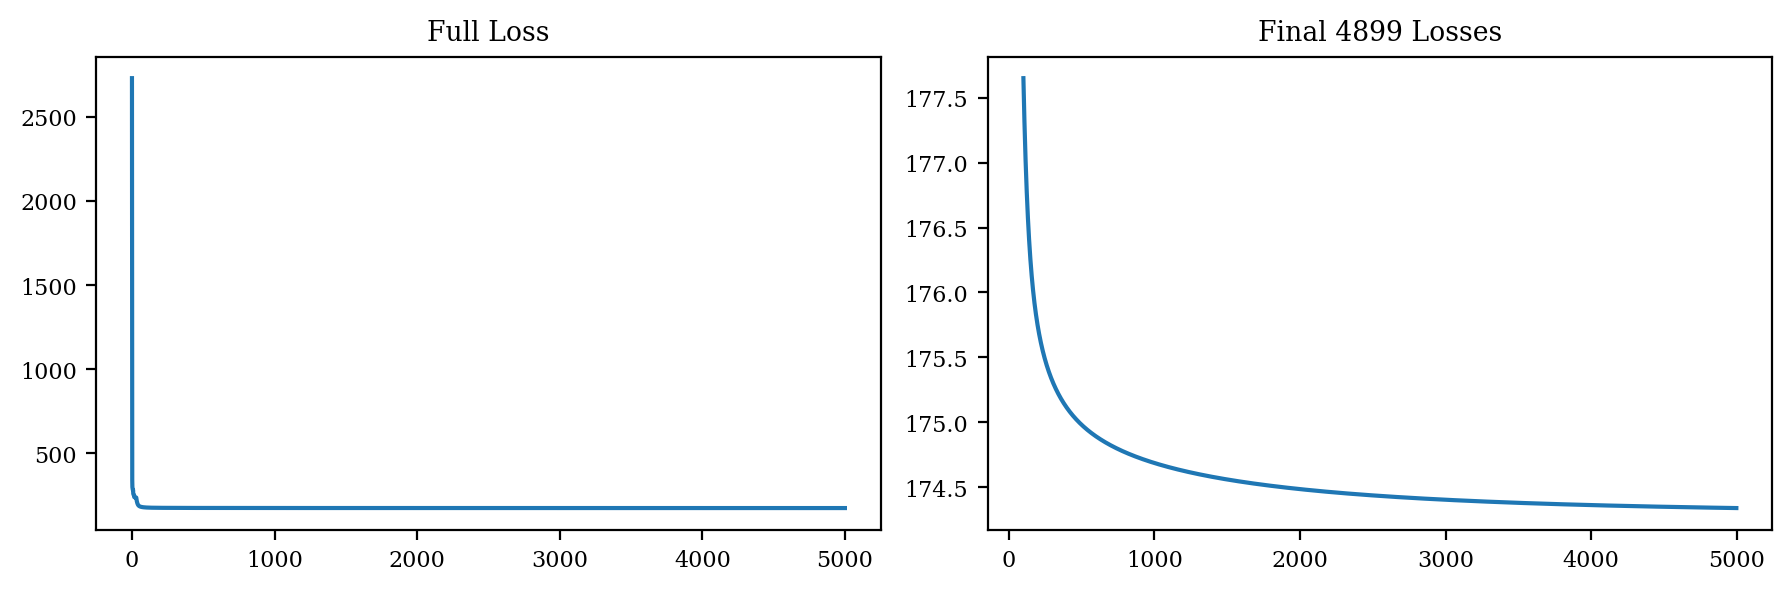

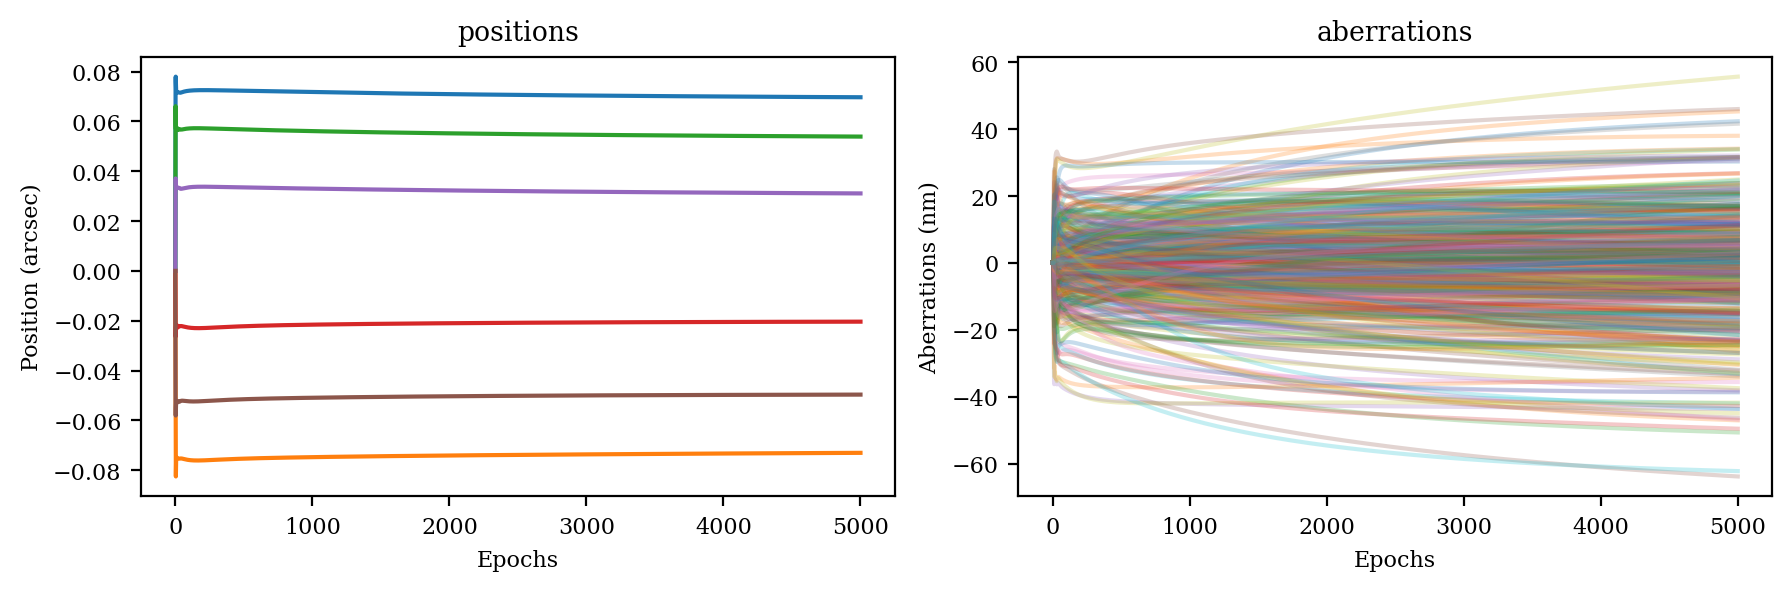

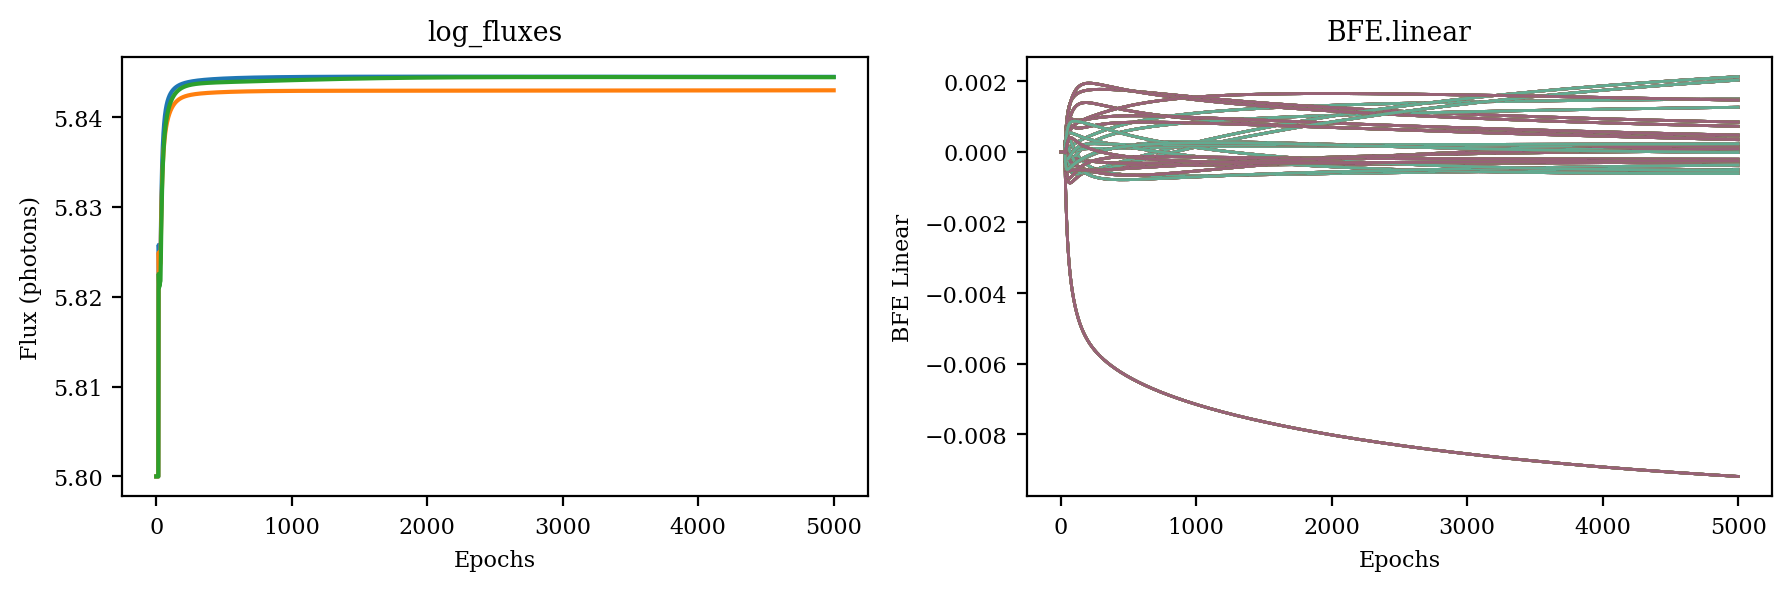

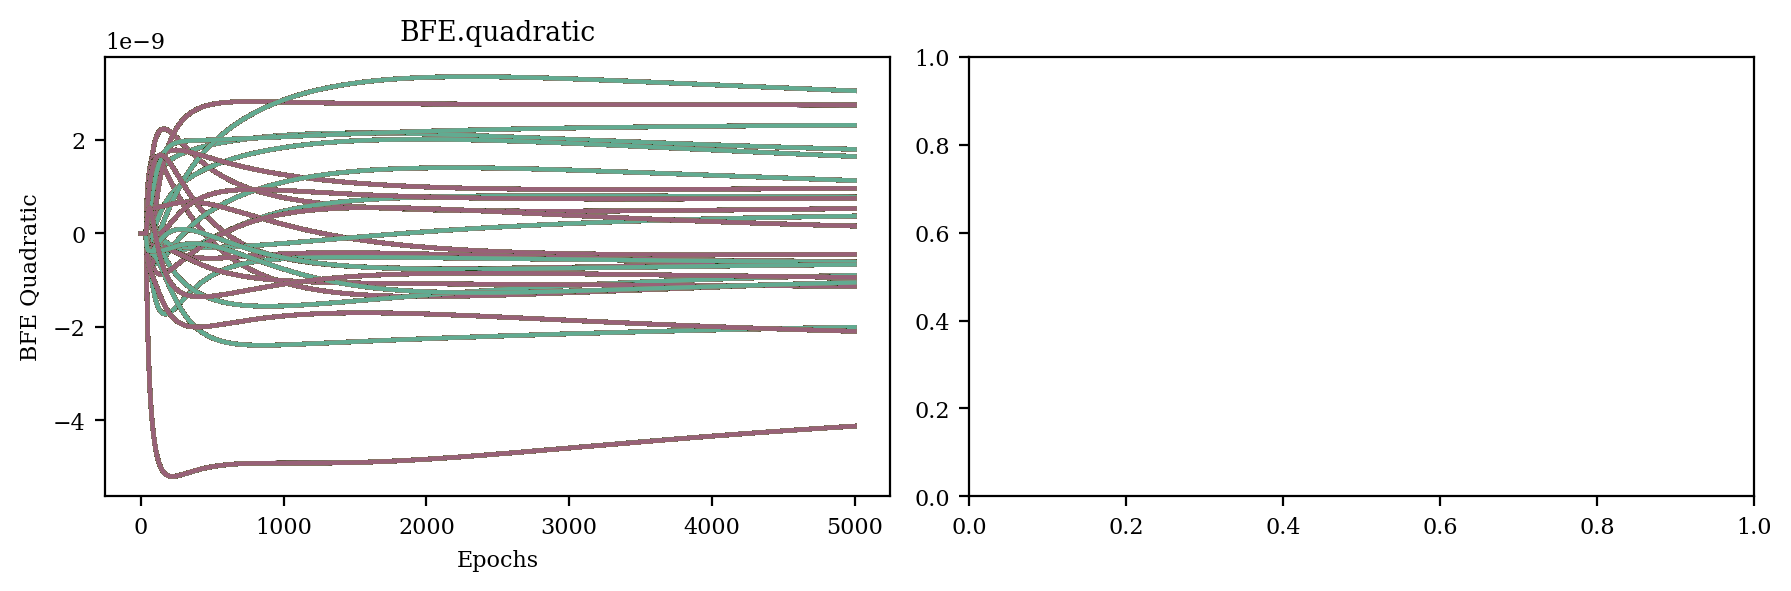

In [14]:
plotting_cal_comparison(cal_final_model, cal_exposures, cal_losses)
plot_params(np.array(cal_losses), cal_params_out, format_fn, k=100)

In [1]:
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ['_', '.', 'x', '+', '*', 'o', 'v', '^', '<', '>', 's', 'p', 'h', 'D', 'd', '|', '_']

plt.figure(figsize=(3, 5))
for expno, all_abs in enumerate(cal_final_model.aberrations.values()):
    m = markers[expno]
    for mirror_no, mirror_ab in enumerate(all_abs):
        c=colors[mirror_no]
        for noll, noll_abs in enumerate(mirror_ab):
            plt.scatter(noll, noll_abs, color=c, marker=m, alpha=0.7)

plt.xlabel("Noll Index")
plt.xticks(range(21))
plt.grid(axis="x", zorder=-100, linestyle='--', alpha=0.3)
plt.ylabel("Zernike Coefficient (nm)")
plt.title('Comparing Aberrations')
plt.show()

# serialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/abberations.zdx", cal_final_model.aberrations)
# np.save("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/BFE_linear.npy", cal_final_model.BFE.linear)
# np.save("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/BFE_quadratic.npy", cal_final_model.BFE.quadratic)


NameError: name 'plt' is not defined

# Io

First, let's set the abberations of our Io model to be what we recovered from the calibrator.

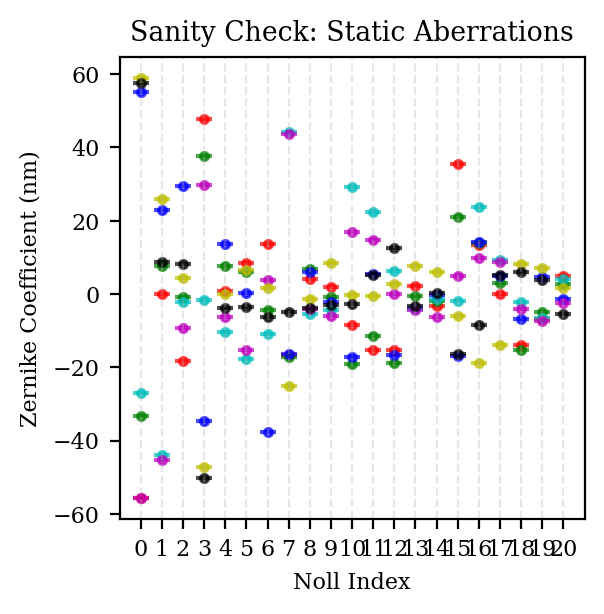

In [16]:
ab_dict = deserialise("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/abberations.zdx")
bfe_linear = np.load("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/BFE_linear.npy")
bfe_quadratic = np.load("/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/jwst/io/arrays/BFE_quadratic.npy")

static_aberations = []

for abbs in ab_dict.values():
    static_aberations.append(abbs)

static_aberations = np.array(static_aberations).mean(axis=0)

model = initial_model
for key in initial_model.keys():
    model.aberrations[key] = static_aberations
model = model.set(
    ["BFE.linear", "BFE.quadratic"],
    [bfe_linear, bfe_quadratic]
)

initial_distribution = model.distribution

plt.figure(figsize=(3, 3))
for expno, all_abs in enumerate(model.aberrations.values()):
    m = markers[expno]
    for mirror_no, mirror_ab in enumerate(all_abs):
        c=colors[mirror_no]
        for noll, noll_abs in enumerate(mirror_ab):
            plt.scatter(noll, noll_abs, color=c, marker=m, alpha=0.7)

plt.xlabel("Noll Index")
plt.xticks(range(21))
plt.grid(axis="x", zorder=-100, linestyle='--', alpha=0.3)
plt.ylabel("Zernike Coefficient (nm)")
plt.title('Sanity Check: Static Aberrations')
plt.show() 

## Visualisation

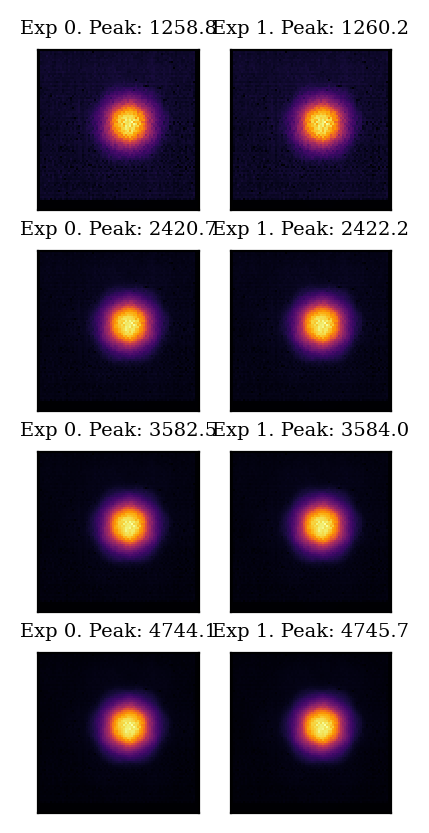

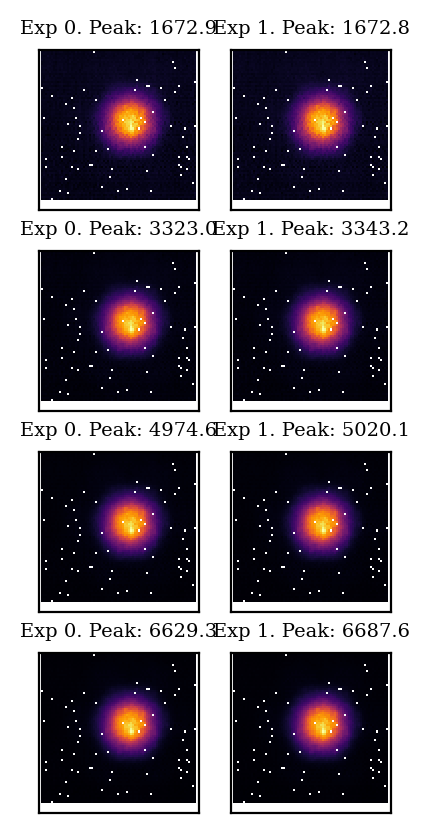

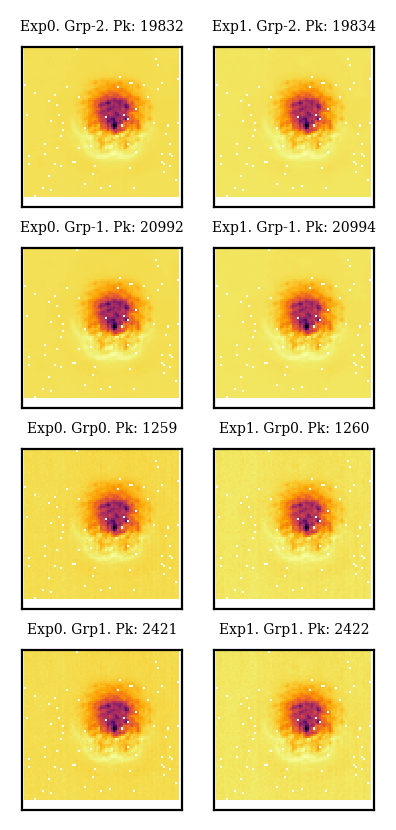

In [17]:
plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(sci_exposures):
    psf_ramp = model_fn(model, exp)
    for group_idx in range(4):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(psf_ramp[group_idx]):.1f}", size=7)
        plt.imshow(psf_ramp[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()


plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(sci_exposures):
    data = exp.data
    for group_idx in range(4):
        plt.subplot(4, 5, exp_idx + 5 * group_idx + 1)
        plt.title(f"Exp {exp_idx}. Peak: {np.nanmax(data[group_idx]):.1f}", size=7)
        plt.imshow(data[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()

plt.figure(figsize=(6, 5))
for exp_idx, exp in enumerate(sci_exposures):
    data = exp.data
    psf_ramp = model_fn(model, exp)
    for i, group_idx in enumerate(np.arange(-2, 2)):
        plt.subplot(4, 5, exp_idx + 5 * i + 1)
        plt.title(f"Exp{exp_idx}. Grp{group_idx}. Pk: {np.nanmax(psf_ramp[group_idx]):.0f}", size=5)
        plt.imshow(psf_ramp[group_idx] - data[group_idx])
        plt.xticks([]); plt.yticks([])
        # plt.colorbar()
plt.show()


# Optimisation

In [18]:
def grad_fn(grads, args, config):
    return grads


def norm_fn(model, args={}):
    """
    Method for returning a new source object with a normalised total
    spectrum and source distribution.

    Returns
    -------
    source : Source
        The source object with the normalised spectrum and distribution.
    """
    spectrum = model.spectrum.normalise()
    distribution_floor = np.maximum(model.distribution, 0.0)
    distribution = distribution_floor / distribution_floor.sum()

    # mask = args['mask']
    # norm_dist = norm_dist * mask

    return model.set(["spectrum", "distribution"], [spectrum, distribution])


In [19]:
delay = lambda lr, s: optax.piecewise_constant_schedule(lr * 1e-16, {s: 1e16})
opt = lambda lr, start: optax.sgd(delay(lr, start), nesterov=True, momentum=0.5)
clip = lambda optimiser, v: optax.chain(optimiser, optax.clip(v))


config = {
    # Crude solver
    "distribution": clip(opt(1e-9, 20), 1),
    "positions": opt(1e-7, 0),
    # "aberrations":  clip(opt(2e1, 100), 1),
    "log_fluxes": opt(3e-7, 10),
    
    # # Read noise refinement
    # "OneOnFs": clip(opt(5e0, 100), 1.0),
    # "biases": clip(opt(3e3, 100), 4.0),
}

# params = list(config.keys())

# Optimisation
final_model, losses, params_out, opt_state = optimise(
    initial_model,
    sci_exposures,
    loss_fn,
    300,
    config,
    norm_fn=norm_fn,
    print_grads=False,
    return_state=True,
    nan_method="none",
)

Step fn compiling...
Compile Time: 0:00:11
Initial Loss: 16,929.53


Loss: 16,929.53, Change: 0.0:   0%|          | 0/299 [00:00<?, ?it/s]

Compile Time: 0:20:48
Final Loss: 536.96


In [20]:
def plotting_io_comparison(model, opt_state, exposures, losses, initial_distribution=initial_distribution):
    fin_dist = model.source.distribution

    try:
        grads = opt_state[0]['0'].inner_state[0][0].trace.distribution  # TODO this is wrong maybe
    except:
        grads = np.zeros_like(fin_dist)
    nrows = 1 + 2 * len(exposures)

    plt.figure(figsize=(15, 3*nrows))
    plt.subplot(nrows, 4, 1)
    plt.imshow(initial_distribution, cmap="afmhot_10u", vmin=0, vmax=np.nanmax(fin_dist))
    plt.colorbar(label="flux")
    plt.title("Io Initial Distribution")
    plt.xticks([0, fin_dist.shape[0]-1])
    plt.yticks([0, fin_dist.shape[1]-1])

    if np.nanmin(fin_dist) < 0:
        rec_vmin=None
    else:
        rec_vmin=0
    plt.subplot(nrows, 4, 2)
    plt.imshow(fin_dist, cmap="afmhot_10u", vmin=rec_vmin, vmax=np.nanmax(fin_dist))
    plt.colorbar(label="flux")
    plt.title("Io Recovered Distribution")
    plt.xticks([0, fin_dist.shape[0]-1])
    plt.yticks([0, fin_dist.shape[1]-1])

    plt.subplot(nrows, 4, 3)
    plt.imshow(grads, **get_residual_bounds(grads))
    plt.colorbar(label="flux / iter")
    plt.title(f"Final Gradient State. Loss: {losses[-1]:.1f}")
    plt.xticks([0, fin_dist.shape[0]-1])
    plt.yticks([0, fin_dist.shape[1]-1])

    for exp_idx, exp in enumerate(exposures):
        model_imgs = model_fn(model, exp)

        for grp_idx, grp_no in enumerate(np.arange(-1, 1)):
            plt.subplot(nrows, 4, 5 + 4*grp_idx + 8*exp_idx)
            plt.imshow(model_imgs[grp_no], cmap="cividis", vmin=0,)
            plt.colorbar(label="flux")
            plt.title(f"Model Image. Exp:{exp_idx}, Grp:{grp_no}")
            plt.xticks([0, fin_dist.shape[0]-1])
            plt.yticks([0, fin_dist.shape[1]-1])

            plt.subplot(nrows, 4, 6 + 4*grp_idx + 8*exp_idx)
            plt.imshow(exp.data[grp_no], cmap="cividis", vmin=0,)
            plt.colorbar(label="flux")
            plt.title(f"Data. Exp:{exp_idx}, Grp:{grp_no}")
            plt.xticks([0, fin_dist.shape[0]-1])
            plt.yticks([0, fin_dist.shape[1]-1])

            residuals, bound_dict = get_residuals(model_imgs[grp_no], exp.data[grp_no], return_bounds=True)
            plt.subplot(nrows, 4, 7 + 4*grp_idx + 8*exp_idx)
            plt.imshow(residuals, **bound_dict)
            plt.colorbar(label="flux")
            plt.title(f"Residuals. Exp:{exp_idx}, Grp:{grp_no}")
            plt.xticks([0, fin_dist.shape[0]-1])
            plt.yticks([0, fin_dist.shape[1]-1])

            llim = exp.loglike_im(model_imgs)
            plt.subplot(nrows, 4, 8 + 4*grp_idx + 8*exp_idx)
            plt.imshow(-llim)
            plt.colorbar()
            plt.title(f"Neg Log Likelihood")
            plt.xticks([0, model_imgs[grp_no].shape[0]-1])
            plt.yticks([0, model_imgs[grp_no].shape[1]-1])

    plt.show()


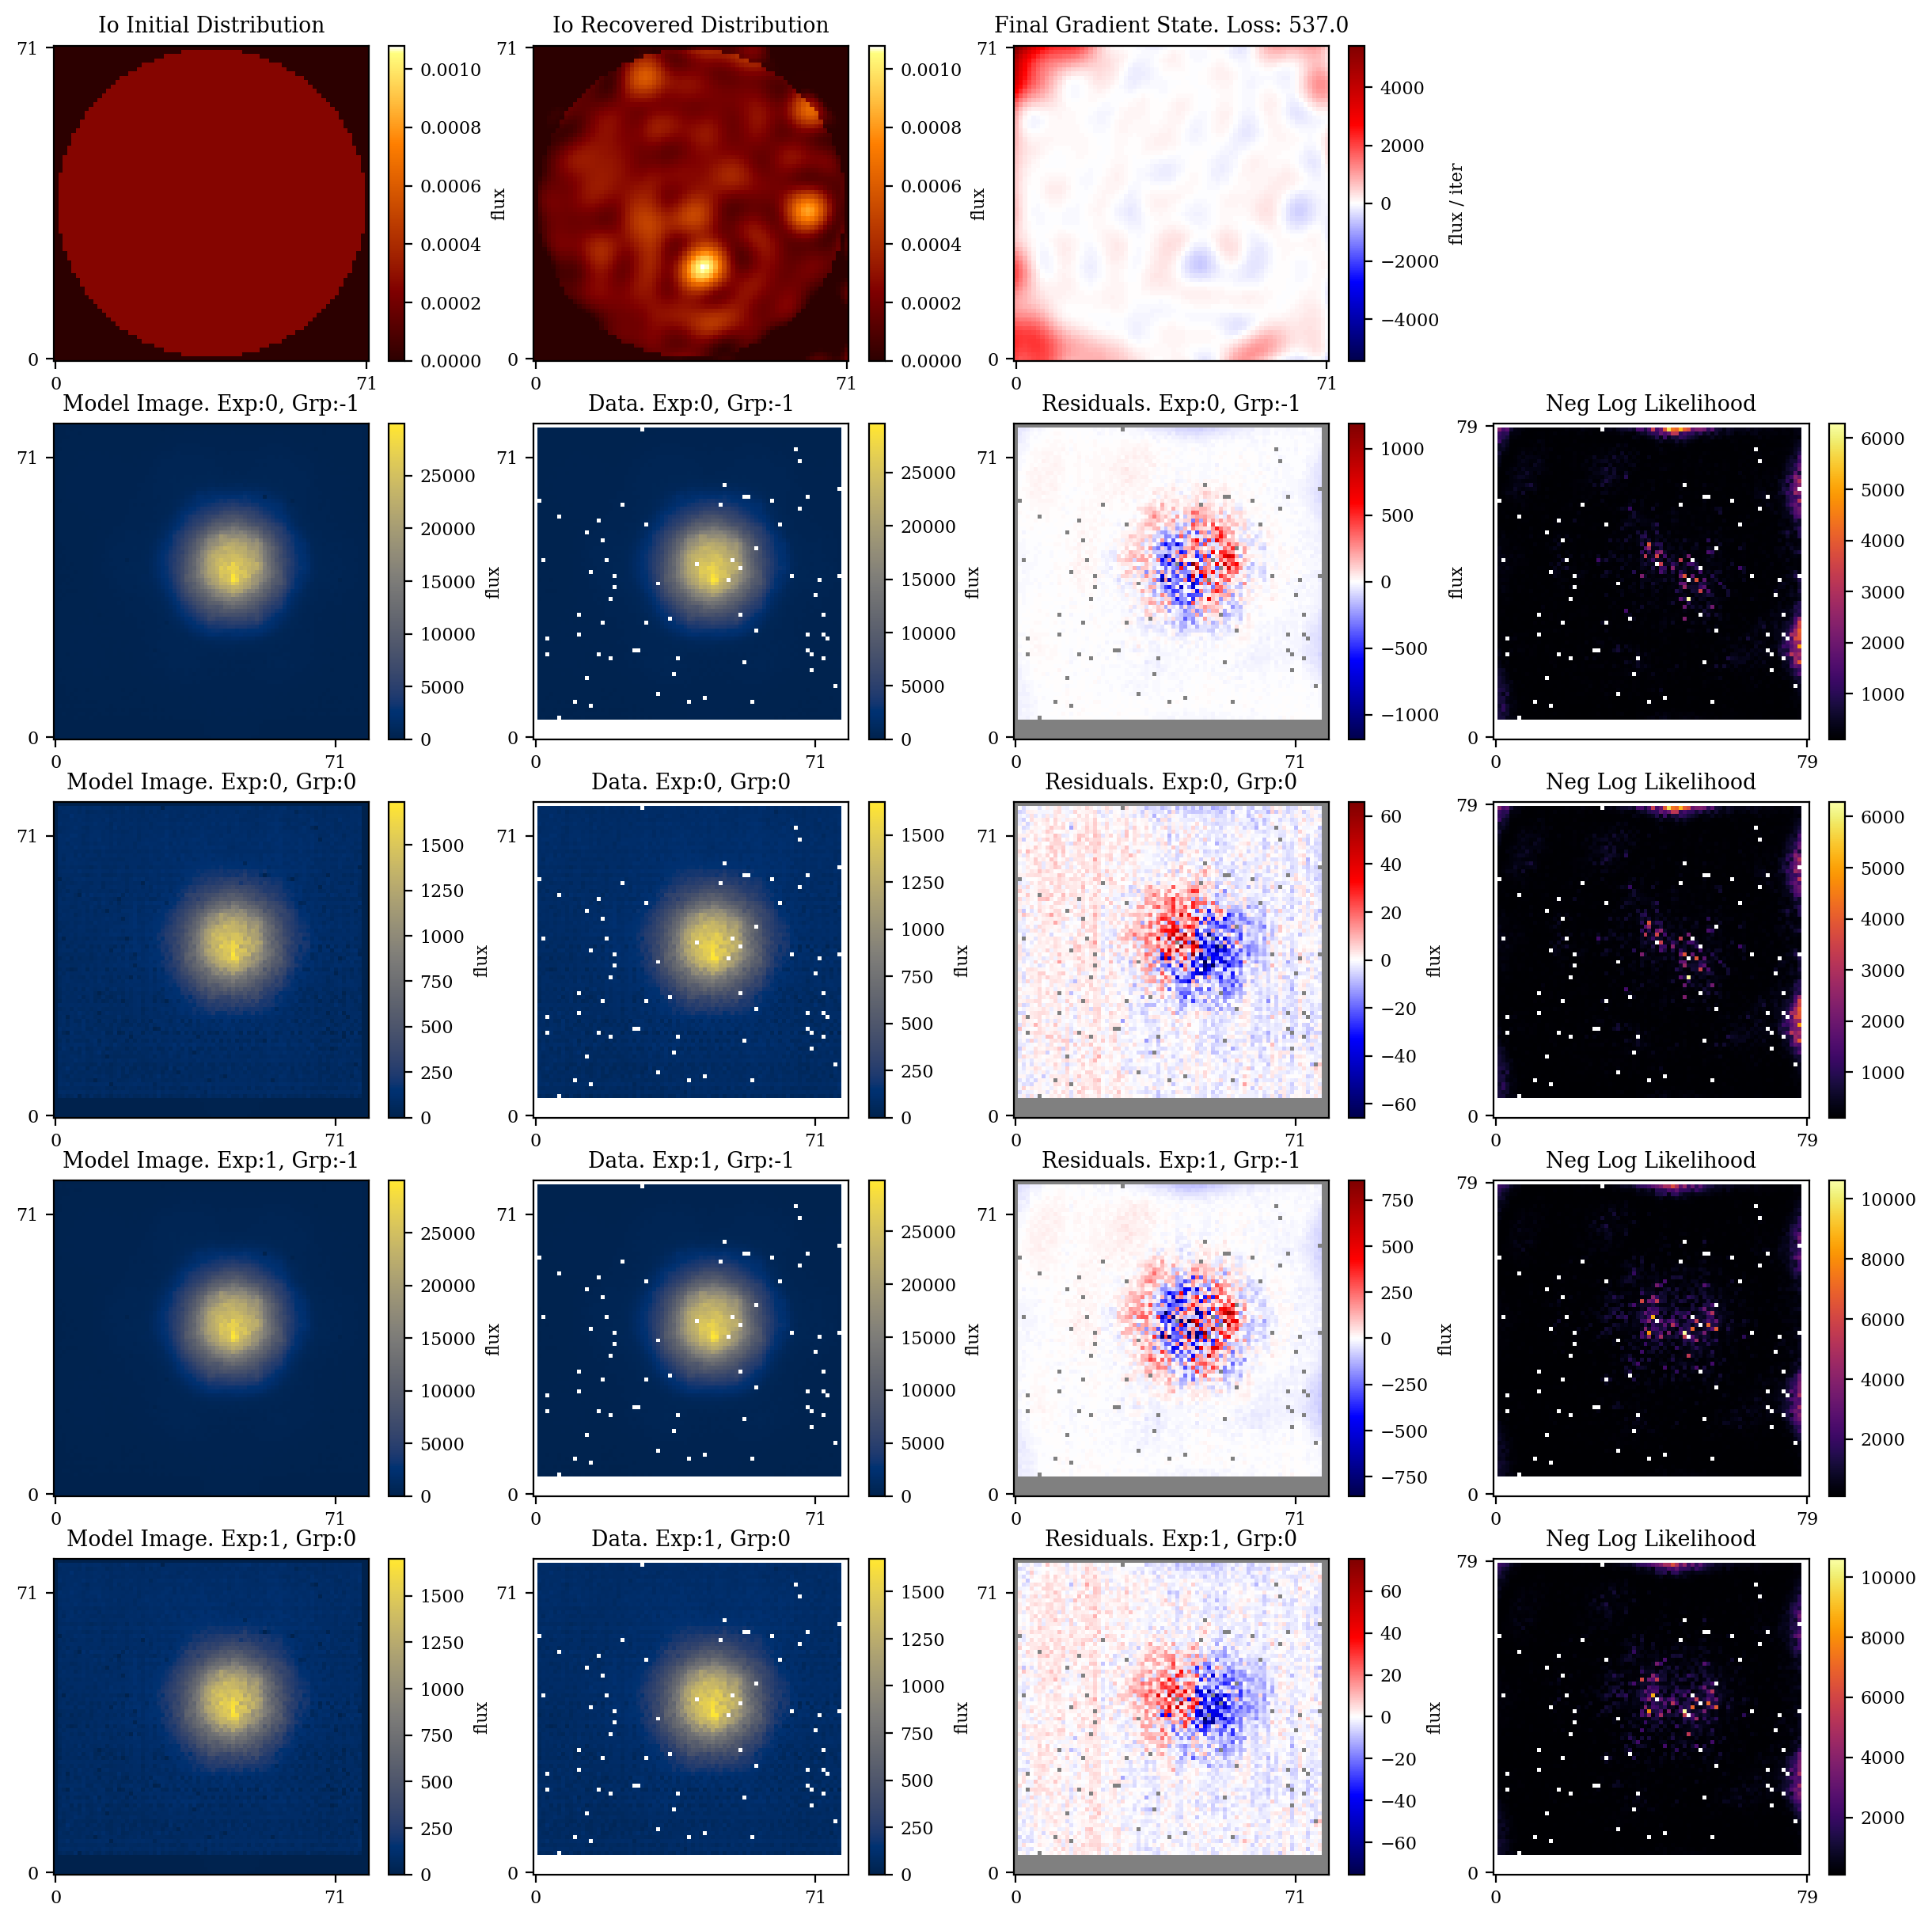

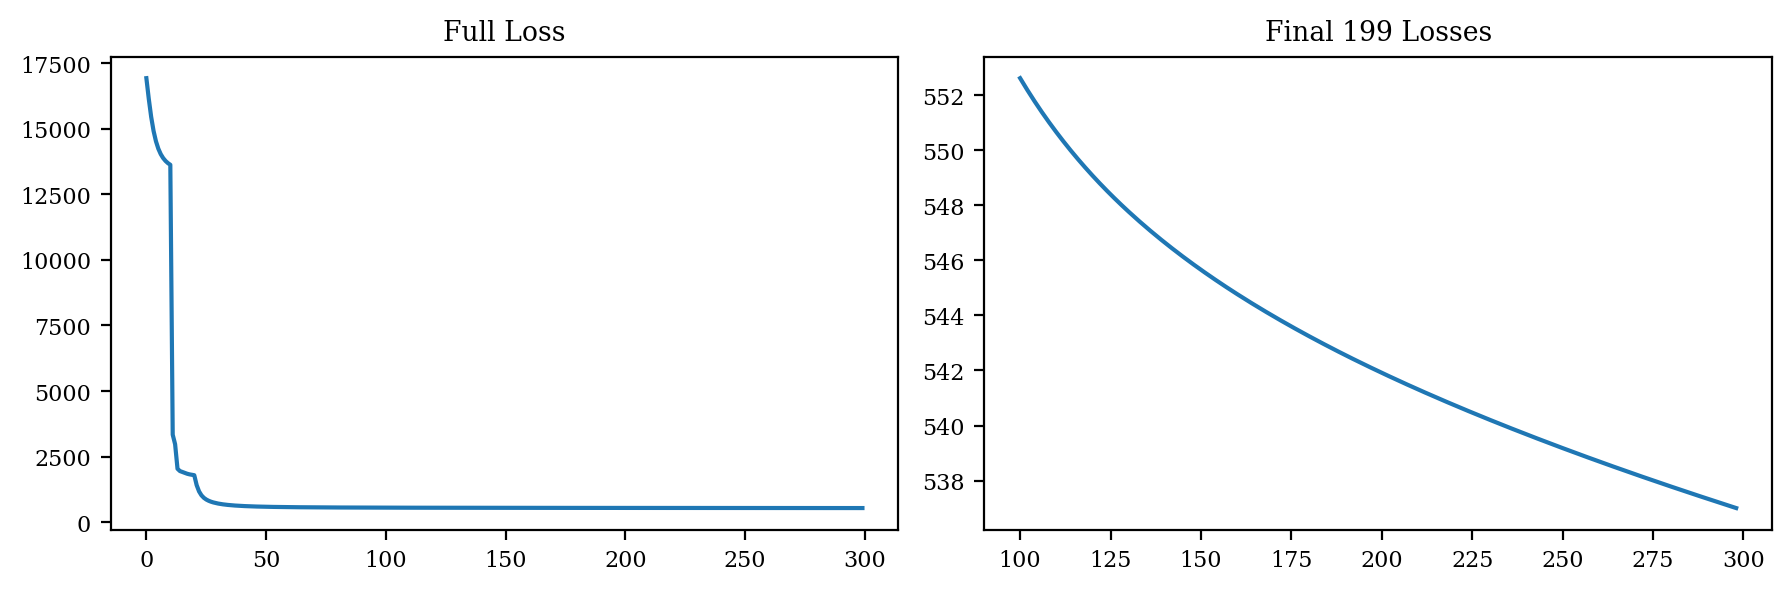

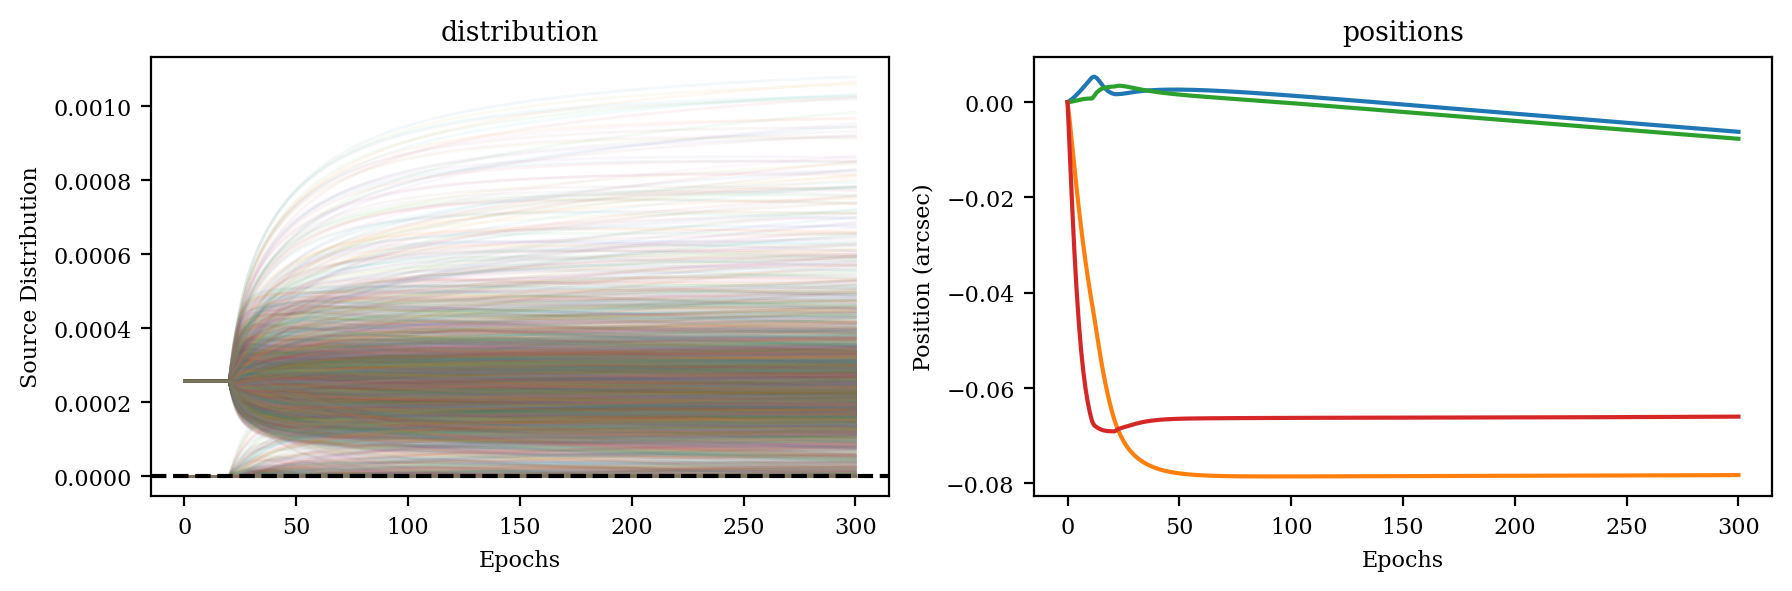

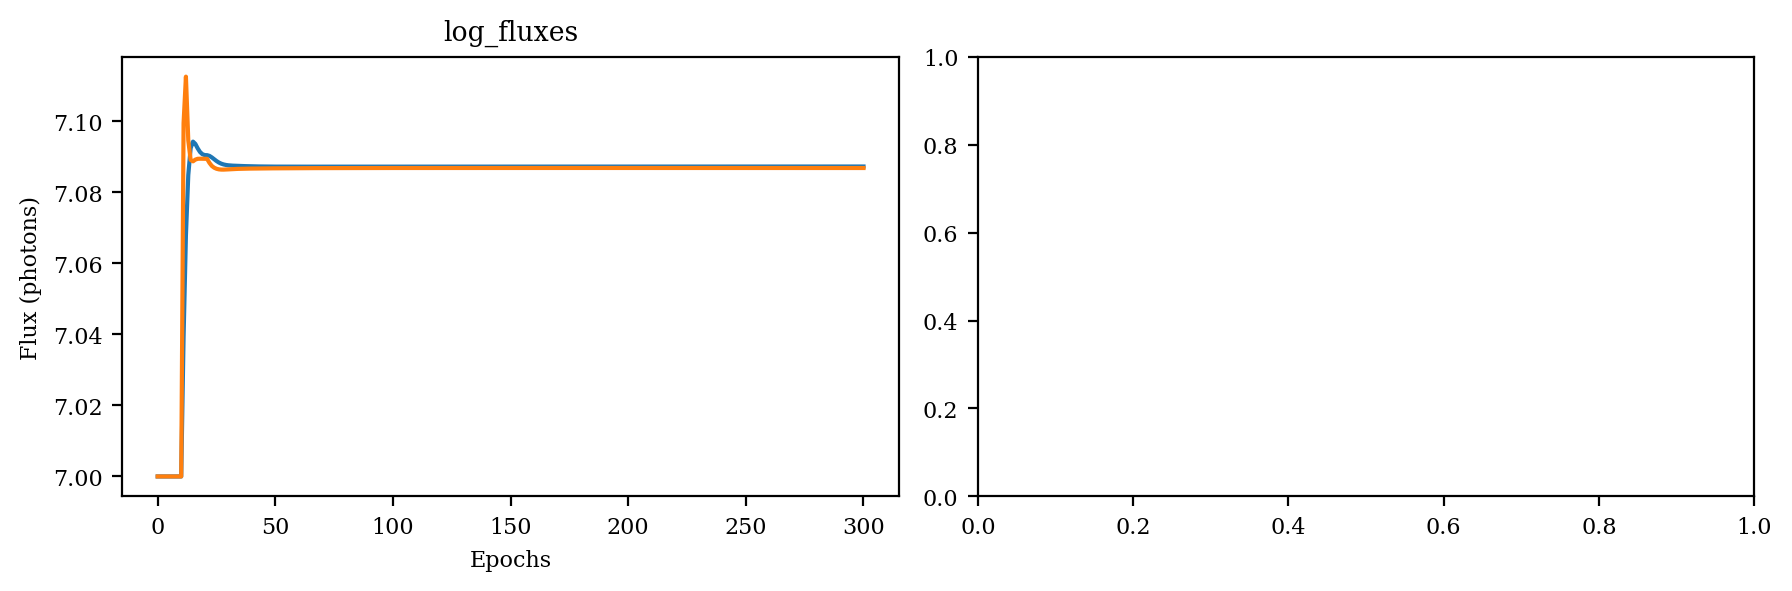

In [21]:
plotting_io_comparison(final_model, opt_state, sci_exposures, losses)
plot_params(np.array(losses), params_out, format_fn, k=100)


In [22]:
np.save("distribution_prior.npy", final_model.distribution)